In [55]:
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
df=pd.read_csv(r'C:\Users\ygu\Documents\ES\High Price\Input Data\2019_2025_07_08_30Min.csv')

In [45]:
def ToD(df,m):
    df['{}'.format(m)]=pd.to_datetime(df['{}'.format(m)],format='%d/%m/%Y %H:%M:%S') 
    df['Month']=df['{}'.format(m)].dt.month # monthly information 
    df['CY']=df['{}'.format(m)].dt.year    # calander year information 
    df['Quarter']=df['{}'.format(m)].dt.quarter# quartely information
    df['FY']=df['{}'.format(m)].map(lambda d: d.year + 1 if d.month > 6 else d.year) # Financial year infromation
    df['Date']=df['{}'.format(m)].dt.date

In [46]:
ToD(df, 'DateTime')

In [47]:
df.drop(columns={"DateTime","Unnamed: 0"},inplace=True)

In [290]:
from numpy.lib.stride_tricks import sliding_window_view as swv
import numpy as np

In [291]:
def ewm_std(x, param=0.99):
    n = len(x)
    coefs = param ** np.arange(n)[::-1]
    mean_x = np.mean(x)
    squared_diff = (x - mean_x) ** 2
    res = np.sqrt(np.dot(squared_diff, coefs) / np.sum(coefs))
    return res

In [315]:
n=365
state='NSW1'

In [316]:
df1=df.groupby(['Date','State']).agg({'RRP':'mean'}).reset_index()

In [317]:
df1=df1[df1['State']==state]

In [318]:
df2=df2.reset_index()
df2.drop(columns='index', inplace=True)

In [319]:
window = n
param  = 0.99
coefs = param ** np.arange(window)[::-1]

In [320]:
x = swv(df1['RRP'], window)
mean_x = x.mean(axis=1)[:, None]
squared_diff = (x - mean_x) ** 2

In [321]:
res = np.sqrt(np.dot(squared_diff, coefs) / np.sum(coefs))
df1['out'] = pd.Series(res, index=df1.index[window-1:])

In [322]:
df1['expected'] = df1.rolling(window=window)['RRP'].apply(ewm_std, raw=True)
np.allclose(df1.loc[window-1:, 'expected'], df1.loc[window-1:, 'out'])

False

In [323]:
df1

,Date,State,RRP,out,expected
1,2019-01-01,QLD1,72.278511,NaN,NaN
6,2019-01-02,QLD1,82.496250,NaN,NaN
11,2019-01-03,QLD1,89.226042,NaN,NaN
16,2019-01-04,QLD1,86.095833,NaN,NaN
21,2019-01-05,QLD1,79.668125,NaN,NaN
...,...,...,...,...,...
12031,2025-08-03,QLD1,63.336875,136.463433,136.463433
12036,2025-08-04,QLD1,82.044375,135.799324,135.799324
12041,2025-08-05,QLD1,73.358333,134.347472,134.347472
12046,2025-08-06,QLD1,83.658542,133.690400,133.690400


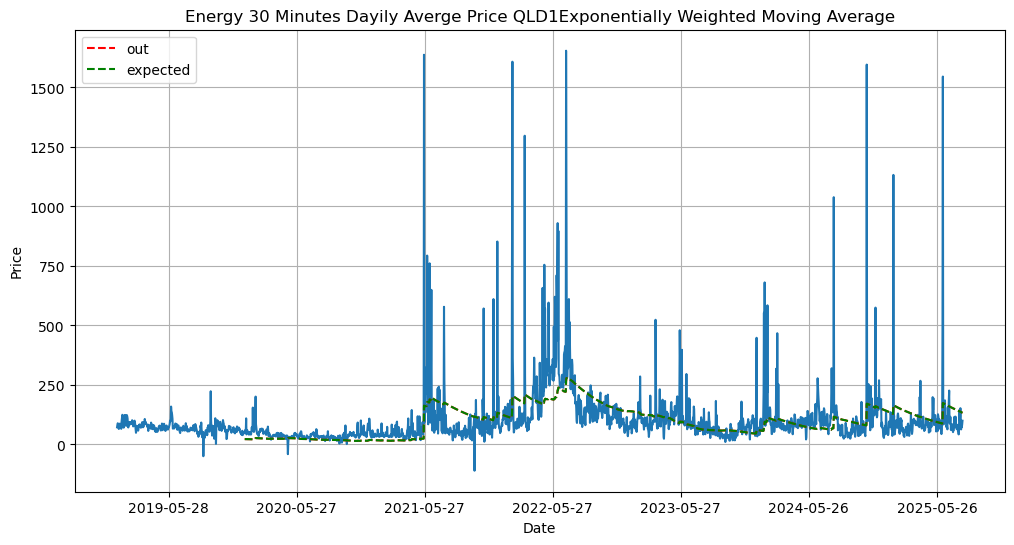

In [324]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
plt.plot(df1['Date'],df1['RRP'] )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=n))
#plt.plot(df1['Date'],df2['Rolling_Average'], label='Rolling_Average 365 Days', color='orange')
plt.plot(df1['Date'],df1['out'], label='out', color='red', linestyle='--')
plt.plot(df1['Date'],df1['expected'], label='expected', color='green', linestyle='--')
plt.title(f'{ticker} {state}Exponentially Weighted Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [325]:
df2=df.groupby(['Date','State']).agg({'RRP':'mean'}).reset_index()

In [326]:
df2=df2[df2['State']==state]
df2=df2.reset_index()

In [327]:
df2.drop(columns='index', inplace=True)
df2['Rolling_Average'] =df2['RRP'].rolling(window=n).mean().reset_index(level=0, drop=True)

In [333]:
df2['StdDev'] = df2['RRP'].rolling(window=n).std()
num_std_dev = 2 # Typically 2 standard deviations
df2['Upper Band'] = df2['Rolling_Average'] + (df2['StdDev'] * num_std_dev)
df2['Lower Band'] = df2['Rolling_Average'] - (df2['StdDev'] * num_std_dev)

In [335]:
ticker = "Energy 30 Minutes Dayily Averge Price" # Example: Apple stock

In [336]:
df2.to_csv(r'C:\Users\ygu\Documents\ES\High Price\Input Data\2019_2025_07_08_30Min_f1.csv')

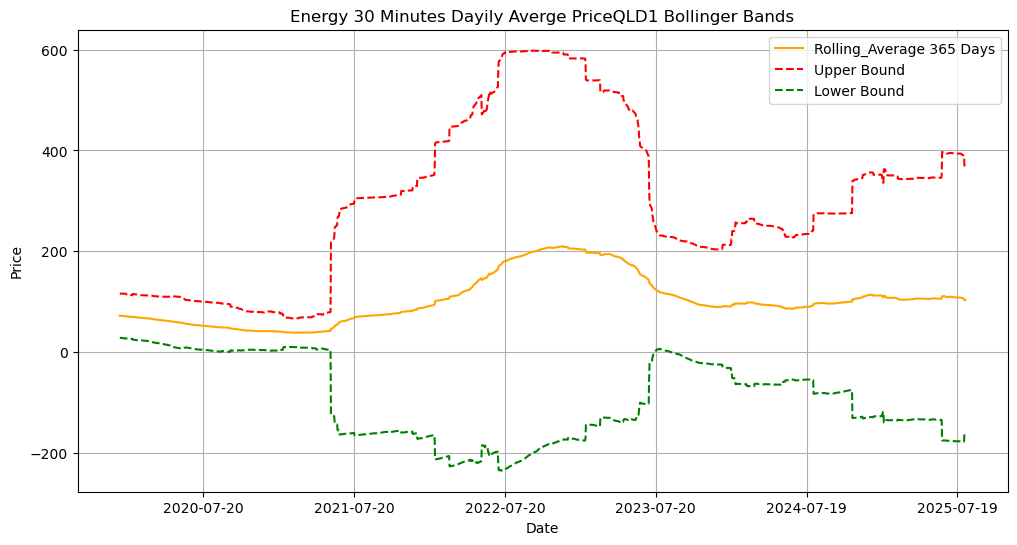

In [338]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
plt.plot(df2['Date'],df2['RRP'] )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=n))
plt.plot(df2['Date'],df2['Rolling_Average'], label='Rolling_Average {} Days'.format(n), color='orange')
plt.plot(df2['Date'],df2['Upper Band'], label='Upper Bound', color='red', linestyle='--')
plt.plot(df2['Date'],df2['Lower Band'], label='Lower Bound', color='green', linestyle='--')
plt.title(f'{ticker}{state} Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()